# CS 109A/AC 209A/STAT 121A Data Science: Homework 2
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, September 21st, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW2.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**


Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [32]:
import numpy as np
import pandas as pd
import random
import sklearn as sk
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.linear_model import LinearRegression as Lin_Reg
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

---

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Galvin, Owen

### Part (b): Course Number

CS 109a, Extension School

### Part (c): Who did you work with?

None

---

## Problem 1: Inside the Models in Scikit-learn

In this problem, we will be implementing K-Nearest Neighbour and simple linear regression for predicting a quantitative variable. We will compare the performance of our implementation with those of Scikit-learn (``sklearn``).

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the dependent variable Y, and the second column containing the independent variable X. 

### Part (a): Implement the models by hand
In this part you **may not** use ``sklearn`` for any task.

In the following, you may use ``numpy`` arrays instead of ``pandas`` dataframes.

- Implement a funtion ``split``, which satifies:
    - input: an ``nx2`` dataframe ``data``, a float ``m``
    - return: an ``nx2`` dataframe ``train`` and an ``nx2`` dataframe ``test``, consisting of ``m`` percent and ``100 - m`` percent of the data, respectively.


- Implement K-Nearest Neighbour for predicting a quantitative variable. That is, write a function, ``knn_predict``, that satisfies:
    - input: an integer ``k``, an ``n x 2`` dataframe training set ``train``, an ``n x 1`` dataframe testing set ``test``
    - return: an ``nx2`` dataframe, whose first column is that of ``test`` and whose second column is the predicted values.



- Implement linear regression for predicting a quantitative variable. That is, write a function ``linear_reg_fit`` that satisfies:
    - input: an ``nx2`` dataframe training set ``train``
    - return: the coefficients of the linear regression model - a float ``slope`` and a float ``intercept``.
    
    
- Write a function ``linear_reg_predict`` that satisfies:
    - input: an ``nx1`` dataframe testing set ``test``, as well as the coefficients of the linear regression model
    - return: an ``nx2`` dataframe, whose first column is that of ``test`` and whose second column is the predicted values.
    
    
- Implement a function ``score`` that satisfies:
    - input: an ``nx2`` dataframe ``predicted``, an ``nx2`` dataframe ``actual`` 
    - return: R^2 coefficient of the fit of the predicted values.

**Solution:**

In [33]:
#Implement a funtion split, which satifies:
#-input: an nx2 dataframe data, a float m
#-return: an nx2 dataframe train and an nx2 dataframe test, 
#        consisting of m percent and 100 - m percent of the data, respectively.

def split(df, m):
    
    #seed was helpful during testing, don't see any real reason to remove
    #ran some tests later and the r-squared output by 109 seed was generally in the middle
    # of the various r-squared reported by both knn & LR when the seed was removed
    np.random.seed(109)
    train_rows = np.random.choice(df.index.values, int(len(df.index)*(m/100.0)), replace=False)
    train_df = df.ix[train_rows]
    test_df = df.drop(train_df.index)
    
    return train_df, test_df


In [34]:
# Implement K-Nearest Neighbour for predicting a quantitative variable. That is, write a function, knn_predict, that :
#- input: an integer k, an n x 2 dataframe training set train, an n x 1 dataframe testing set test
#- return: an nx2 dataframe, whose first column is that of test and whose second column is the predicted values.

#general comment, I would have preferred to re-write the various function bodies to be more flexible
# and not expect a specific column name, e.g. 'x' or 'y' or 'pred_y' but doing so in terms of the homework
# deadline isn't going to work and any attempt at this point is likely to blow up. Personally, I would have
# at least included additional params that indicated dependent vs. independent column names but the instructions
# specified the parameters. And also, I've come across it more than once in various Python & R libraries
# where they expected a specific column name... though of course one can read the documentation in those cases.
#Most of my comments are being written after the homework is 95% done, so they will reflect the fact that
# there is room for improvement but it is too close to ship date to make any substantive changes.

def knn_predict(k, train, test):

    #defining here is good enough for now
    #train_sorted = train.sort('x')
    
    def get_neighbors(val):
        
        distances = abs(train['x'] - val)
        distances.sort()
        #distances was in-place sorted, pull out k index values from train that had an x closest to 'this' x from test
        neighbor_idx = distances[:k].index.values
        #these two are debug, makes it easier to eyeball the results
        idx_of_min = distances.idxmin()
        closest = train.loc[idx_of_min]
        #pull out the train rows matching the indexes of those closest x values
        pred = train[train.index.isin(neighbor_idx)]
        #and isolate only the corresponding dependent values
        near_values = pred['y']
        
        return pd.Series({'pred_y': np.mean(near_values), 
                          'closest_x': closest['x'],
                          'closest_y': closest['y'],
                          'idx_of_match': idx_of_min, 
                          'neighbors': [round(n,2) for n in near_values]} ) 

    predict_srs = test.apply(lambda row: get_neighbors(row))
    #merge the subtype predictions and train-match index value into a full dataframe       
    test_with_pred = pd.merge(pd.DataFrame(test), pd.DataFrame(predict_srs['pred_y']), right_index=True, left_index=True)
    #debug line below, return all that debug info from get_neighbors
    #test_with_pred = pd.merge(pd.DataFrame(test), pd.DataFrame(predict_srs), right_index=True, left_index=True)

    return test_with_pred


# some in-cell debug info, ignore - I feel safer not deleting
# -----------------------------------------------------------
#full_df = pd.read_csv('./dataset/dataset_1_full.txt')
#full_df = full_df.head(200)
#train_df, test_df = split(full_df, 70)
#print train_df.head()

#k_val = 11 
#out_df = knn_predict(k_val, train_df, test_df['x'])
#out_df.head(20)

In [35]:
#Implement linear regression for predicting a quantitative variable. That is, write a function linear_reg_fit that :
# - input: an nx2 dataframe training set train
# - return: the coefficients of the linear regression model - a float slope and a float intercept.

def linear_reg_fit(train):
    
    x_mean = np.mean(train['x'])
    y_mean = np.mean(train['y'])
    x_diffs = [x - x_mean for x in train['x']]
    y_diffs = [y - y_mean for y in train['y']]
    slope = sum(np.multiply(x_diffs, y_diffs))/sum(x**2 for x in x_diffs) 
    intercept = y_mean - slope*x_mean

    return slope, intercept


In [36]:
#Write a function linear_reg_predict that satisfies:
# - input: an nx1 dataframe testing set test, as well as the coefficients of the linear regression model
# - return: an nx2 dataframe, whose first column is that of test and whose second column is the predicted values.

def linear_reg_predict(test, slope, intercept):

    #I'm sure this is an area for improvement, something simpler
    # I think my first approach used apply, then a problem with the type of the test arg(?)
    # either way, I'm stuck with it now
    df = pd.DataFrame({'x': test['x']})
    df['pred_y'] = test.apply(lambda val : val * slope + intercept)

    return df


In [37]:
#Implement a function score that satisfies:
# - input: an nx2 dataframe predicted, an nx2 dataframe actual
# - return: R^2 coefficient of the fit of the predicted values.

def score(actual, predicted):
    
    rss = sum((actual['y']-predicted['pred_y']) **2)
    y_mean_actual = np.mean(actual['y'])
    tss = sum((actual['y']-y_mean_actual) **2)
    r_squared = 1 - (rss/tss)
    
    return r_squared


### Part (b): Compare with ``sklearn``

- Load the contents of ``dataset_1_full.txt`` into a ``pandas`` dataframe, or ``numpy`` array. 


- Use your functions from Part (a) to split the data into training and testing sets (70-30). Evaluate how KNN and linear regression each perform on this dataset.


- Use ``sklearn`` to split the data into training and testing sets (70-30). Use ``sklearn`` to evaluate how KNN and linear regression each perform on this dataset.


- Use Python's ``time`` library to measure how well your implementations compare with that of ``sklearn``. What can you do (algorithmically or codewise) to make your implementation faster or more efficient?

**Solution:**

In [38]:
#Use your functions from Part (a) to split the data into training and testing sets (70-30).
#Evaluate how KNN and linear regression each perform on this dataset.

full_df = pd.read_csv('./dataset/dataset_1_full.txt')
train_df, test_df = split(full_df, 70)

#had finished problem 2 already and from there estimate 20 was a decent k value to test with
k=20
out_df = knn_predict(k, train_df, test_df['x'])
knn_r_squared = score(test_df, out_df)

#now for my linear regression attempts
slope, intercept = linear_reg_fit(train_df)
#reduce test to nx1... should probably have used resize but Pandas is new to me
test_data = pd.DataFrame({'x': test_df['x']})
out_df = linear_reg_predict(test_data, slope, intercept)
lr_r_squared = score(test_df, out_df)

print 'KNN R-squared score (k={0}): {1}'.format(k, knn_r_squared)
print 'Linear Regression R-squared score: {0}'.format(lr_r_squared)
print ('With a k={0} (and a random seed in my split = 109, performance of both models is almost the same. '
       'A little over 40% of the variance inherent in the y values is '
       'explained by each of the given models.'.format(k))
print
print 'I ran some quick tests without the seed and the R-squared generally remained between .30 and .45'
print 'With these linear regression tended to outperform knn (which isn''t what I saw with seed = 109),'
print 'but difference was quite small.'


KNN R-squared score (k=20): 0.407456663467
Linear Regression R-squared score: 0.404231916849
With a k=20 (and a random seed in my split = 109, performance of both models is almost the same. A little over 40% of the variance inherent in the y values is explained by each of the given models.

I ran some quick tests without the seed and the R-squared generally remained between .30 and .45
With these linear regression tended to outperform knn (which isnt what I saw with seed = 109),
but difference was quite small.


In [39]:
#Use sklearn to split the data into training and testing sets (70-30). 
#Use sklearn to evaluate how KNN and linear regression each perform on this dataset.

full_df = pd.read_csv('./dataset/dataset_1_full.txt')

#setting a seed here so my comments can refer to a specific split
np.random.seed(109)
#import in initial notebook: from sklearn.cross_validation import train_test_split as sk_split
train_np, test_np = sk_split(full_df, train_size=0.7)
#I hadn't used sklearn to split until too late in the dev process, after I had written everything
# to work with pandas dataframes, so safest route is simply to re-formulate the output of sk_split as dataframes
train_df = pd.DataFrame(train_np, columns=['x','y'])
test_df = pd.DataFrame(test_np, columns=['x','y'])

# *** but using the train/test df from my split function seems to generally result in a lower r-squared
# vs. using split from sklearn, though that was from ad-hoc observations over some quick tests w/o a seed.
# Perhaps sk_split looks at the actual data when doing the split? and takes the actual values into account
# when making the split? I was aware of something like that in R, probably even more important as the
# the number and diversity of predictor variables increases

#sklearn KNN
neighbors = KNN(n_neighbors=k)
num_rows_test = len(test_df)
#my sklearn KNN attempts required same dimensions for train & test, so cut the train rows down to size of test
x = train_df['x'][:num_rows_test].reshape(-1,1)
y = train_df['y'][:num_rows_test].reshape(-1,1)
neighbors.fit(x, y)
test_x = test_df['x'].reshape(-1,1)
test_y = test_df['y'].reshape(-1,1)
sklearn_knn_r = neighbors.score(test_x, test_y)


regression = Lin_Reg()
lr_train_x = train_df['x'].reshape(-1,1)
lr_train_y = train_df['y'].reshape(-1,1)
regression.fit(lr_train_x, lr_train_y)
pred = regression.predict(test_x)
sklearn_lr_r = regression.score(test_x, test_y)

print 'sklearn KNN R-squared score (k={0}): {1}'.format(k, sklearn_knn_r)
print 'sklearn Linear Regression R-squared score: {0}'.format(sklearn_lr_r)
print ('With a k={0}, and a seed = 109, performance of Linear regression was notably superior to KNN. '
 'But both r-square scores were dependent on the split - LR generally had higher r-square but not '
 'necessarily as big a difference as observed with seed = 109. I would think the differences would '
 'decrease with a larger dataset.'.format(k))

##############
print 
print
print '* while reviewing homework for submission I became unsure if the goal might have been to use '
print ' sklearn''s split with my lr/knn functions, so I''ll quickly output those results, just in case'
print

out_df = knn_predict(k, train_df, test_df['x'])
knn_r_squared = score(test_df, out_df)

#now for my linear regression attempts
slope, intercept = linear_reg_fit(train_df)
#reduce test to nx1... should probably have used resize but Pandas is new to me
test_data = pd.DataFrame({'x': test_df['x']})
out_df = linear_reg_predict(test_data, slope, intercept)
lr_r_squared = score(test_df, out_df)

print 'using the split provided by sklearn to inform my knn and linear regression models'
print 'KNN R-squared score (k={0}): {1}'.format(k, knn_r_squared)
print 'Linear Regression R-squared score: {0}'.format(lr_r_squared)
print 'With a k={0}, Linear Regression''s performance is almost 10% higher than that of knn.'.format(k)


sklearn KNN R-squared score (k=20): 0.376006966135
sklearn Linear Regression R-squared score: 0.460308011285
With a k=20, and a seed = 109, performance of Linear regression was notably superior to KNN. But both r-square scores were dependent on the split - LR generally had higher r-square but not necessarily as big a difference as observed with seed = 109. I would think the differences would decrease with a larger dataset.


* while reviewing homework for submission I became unsure if the goal might have been to use 
 sklearns split with my lr/knn functions, so Ill quickly output those results, just in case

using the split provided by sklearn to inform my knn and linear regression models
KNN R-squared score (k=20): 0.410960830876
Linear Regression R-squared score: 0.460308011285
With a k=20, Linear Regressions performance is almost 10% higher than that of knn.


In [10]:
#Use Python's time library to measure how well your implementations compare with that of sklearn.

#ran out of time on the assignment and this is the one part I won't have time (ha ha) to do much with
start = time.time()
for i in xrange(10):
    #my knn didn't require same length df, but for performance test cut it down like for sklearn
    num_rows_test = len(test_df)
    out_df = knn_predict(k, train_df.head(num_rows_test), test_df['x'])
    knn_r_squared = score(test_df, out_df)
end = time.time()
print 'my knn, loop 10 times, execution time: {0}'.format(end - start)

start = time.time()
for i in xrange(10):
    #sklearn KNN ... I'm putting everything I used to implement, sklearn's performance will be underestimated
    neighbors = KNN(n_neighbors=k)
    num_rows_test = len(test_df)
    #my sklearn KNN attempts required same dimensions for train & test, so cut the train rows down to size of test
    x = train_df['x'][:num_rows_test].reshape(-1,1)
    y = train_df['y'][:num_rows_test].reshape(-1,1)
    neighbors.fit(x, y)
    test_x = test_df['x'].reshape(-1,1)
    test_y = test_df['y'].reshape(-1,1)
    sklearn_knn_r = neighbors.score(test_x, test_y)
end = time.time()
print 'sklearn knn, loop 10 times, execution time: {0}'.format(end - start)


start = time.time()
for i in xrange(10):
    slope, intercept = linear_reg_fit(train_df)
    #reduce test to nx1... should probably have used resize but Pandas is new to me
    test_data = pd.DataFrame({'x': test_df['x']})
    out_df = linear_reg_predict(test_data, slope, intercept)
    lr_r_squared = score(test_df, out_df)
end = time.time()
print 'my linear regression, loop 10 times, execution time: {0}'.format(end - start)


start = time.time()
for i in xrange(10):
    regression = Lin_Reg()
    lr_train_x = train_df['x'].reshape(-1,1)
    lr_train_y = train_df['y'].reshape(-1,1)
    regression.fit(lr_train_x, lr_train_y)
    pred = regression.predict(test_x)
    sklearn_lr_r = regression.score(test_x, test_y)
end = time.time()
print 'sklearn linear regression, loop 10 times, execution time: {0}'.format(end - start)

print
print 'sklearn, unsurprisingly, is notably quicker than my code, though the difference is more present in knn comparison.'
print 'In one of my tests, sklearn''s knn was something like 176x quicker, while it''s LR was only 7 times faster.'


my knn, loop 10 times, execution time: 3.13700008392
sklearn knn, loop 10 times, execution time: 0.0270001888275
my linear regression, loop 10 times, execution time: 0.0439999103546
sklearn linear regression, loop 10 times, execution time: 0.00999999046326

sklearn, unsurprisingly, is notably quicker than my code, though the difference is more present in knn comparison.
In one of my tests, sklearns knn was something like 176x quicker, while its LR was only 7 times faster.


#### What can you do (algorithmically or codewise) to make your implementation faster or more efficient?  
Three areas for exploration come to mind:
- use numpy more vs. pandas, or at least remove all the extra layers of crud I added just so things worked
- related to above, I don't know Numpy/Pandas well at all, so there most be known approaches in both libraries that could help improve performance
- and similarly, I'm sure there are more efficient mathematical approaches, things related to matrix algebra come to mind, but my knowledge there isn't very deep

(and on the far edge, there is of course the possibility of doing something natively in C and using python to consume the results)

## Problem 2: Handling Missing Data

In this problem, we will be handling the problem of datasets with missing values. Clearly, we cannot simply remove entire rows or columns that contain missing values. In this problem, we explore two different ways to fill in missing values.

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the dependent variable Y, and the second column containing the independent variable X. 

In this problem, you **may not** use ``sklearn`` or build-in ``pandas`` functions to **directly fill in missing values**. Usage of these libraries/pakcages for related tasks is fine.

### Part (a): Model Based Data Imputation

- Describe in detail how predictive models for data (like KNN and simple linear regression) can be used to fill in missing values in a data set.


- Implement your scheme. That is, write code (preferably a function ``fill`` or two functions ``fill_knn``, ``fill_lin_reg``), which takes an ``n x 2`` dataframe or array with values missing in the 2nd column and fills in these values using KNN and linear regression. 


- You need to, also, write code to evaluate the quality of the values you've filled in.

**Solution:**

In short, the data set is split into a train and test dataset, where the former represents the dataset with the values and test the dataset missing values. Assuming we are only missing values from one variable, said values can be imputed by training a model on train and applying on test. Predicted values represent the formerly missing data.  
In theory multiple missing variables could be handled one at a time, by training a model in order to predict each successive variable, again with applicable train/test sets both having and missing the value. One expects predicted values will have less validity the larger is the proportion of missing values to actual values.  
In a KNN scenario the nearest neigbors, using the input variable(s) as a measure of nearness, can be averaged to predict & fill in a numeric value. A categorical value could be predicted using a majority vote amongst the neighbors... my thought here is that a larger N would be preferable, to increase accuracy of majority voting.  
With linear regression the missing value is essentially the x in y = mx + b of the linear model fit on the training data, where b is the intercept of the model and m is the slope.

In [40]:
# FROM LAB 2 NOTEBOOK
# - .score() method on each model is an indicator of the quality of the values being filled in, i.e. of the predictions


#--------  fill_knn
#input: missing_df (dataframe), full_df (dataframe), no_y_ind (indices of missing values), 
#       with_y_ind (indices of non-missing values), k (integer)
#output: predicted_df (dataframe), r (float)

def fill_knn(missing_df, full_df, no_y_ind, with_y_ind, k):
    #preparing data in array form
    x_train = missing_df.loc[with_y_ind, 'x'].values
    x_train = x_train.reshape((len(with_y_ind), 1))  # (#rows, 1 column)
    y_train = missing_df.loc[with_y_ind, 'y'].values
    x_test = missing_df.loc[no_y_ind, 'x'].values.reshape((len(no_y_ind), 1))
    y_test = full_df.loc[no_y_ind, 'y'].values
    
    #fit knn model
    neighbours = KNN(n_neighbors=k)
    neighbours.fit(x_train, y_train)
    
    #predict y-values
    predicted_y = neighbours.predict(x_test)
    
    #score predictions -- this is the code that can be used to evaluet quality of filled in values
    r = neighbours.score(x_test, y_test)
    
    #fill in missing y-values
    predicted_df = missing_df.copy()
    predicted_df.loc[no_y_ind, 'y'] = pd.Series(predicted_y, index=no_y_ind)
    
    return predicted_df, r

#--------  fill_ling_reg
#input: missing_df (dataframe), full_df (dataframe), no_y_ind (indices of missing values), 
#       with_y_ind (indices of non-missing values), k (integer)
#output: predicted_df (dataframe), r (float)


def fill_lin_reg(missing_df, full_df, no_y_ind, with_y_ind):
    #preparing data in array form
    x_train = missing_df.loc[with_y_ind, 'x'].values.reshape((len(with_y_ind), 1))
    y_train = missing_df.loc[with_y_ind, 'y'].values
    x_test = missing_df.loc[no_y_ind, 'x'].values.reshape((len(no_y_ind), 1))
    y_test = full_df.loc[no_y_ind, 'y'].values
    
    #fit linear model
    regression = Lin_Reg()
    regression.fit(x_train, y_train)
    
    #predict y-values
    predicted_y = regression.predict(x_test)
    
    #score predictions
    r = regression.score(x_test, y_test)
    
    #fill in missing y-values
    predicted_df = missing_df.copy()
    predicted_df.loc[no_y_ind, 'y'] = pd.Series(predicted_y, index=no_y_ind)
    
    return predicted_df, r
    

### Part (b): Which Model is Better?

- For datasets ``dataset_1_missing.txt`` to ``dataset_6_missing.txt``, compare the result of filling in the missing values using KNN and linear regression, using both the R^2 coefficient as well as data visualization. 


- Use your analysis to form conjectures regarding the conditions under which KNN performs better than linear regression, under which linear regression performs better than KNN and under which both perform equally (well or poorly). Explain in detail exactly what might cause each model to fail or perform well. 



- Using ``dataset_1_missing.txt``, explain the impact of the choice of $k$ on the performance of KNN. 


Use numerical analysis and data visualization to support every part of your argument.

**Solution:**

In [41]:
# FROM LAB NOTEBOOK, modify to add param for additional title text, add x,y labels and other prettification

#--------  plot_missing
#input: ax1 (axes), ax2 (axes), 
#       predicted_knn (nx2 dataframe with predicted vals), r_knn (float),
#       predicted_lin (nx2 dataframe with predicted vals), r_lin (float), 
#       k (integer),
#       no_y_ind (indices of rows with missing y-values),
#       with_y_ind (indices of rows with no missing y-values)
#output: ax1 (axes), ax2 (axes)

def plot_missing(ax1, ax2, predicted_knn, r_knn, predicted_lin, r_lin, k, no_y_ind, with_y_ind, top_title, plot_both=True):
    
    knn_actual = ax1.scatter(predicted_knn.loc[with_y_ind]['x'].values, 
                predicted_knn.loc[with_y_ind]['y'].values, 
                color='blue')

    knn_pred = ax1.scatter(predicted_knn.loc[no_y_ind]['x'].values, 
                predicted_knn.loc[no_y_ind]['y'].values, 
                color='red')
    ax1.set_title('{0} (k={1})\nKNN, R$^2$: {2:.4f}'.format(top_title, k, r_knn))
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    ax1.legend((knn_actual, knn_pred),
               ('actual', 'predicted'),
               scatterpoints=1,
               loc='upper left',
               ncol=1,
               fontsize=8)

    if plot_both:
        lr_actual = ax2.scatter(predicted_lin.loc[with_y_ind]['x'].values, 
                    predicted_lin.loc[with_y_ind]['y'].values,
                    color='blue')

        lr_pred = ax2.scatter(predicted_lin.loc[no_y_ind]['x'].values, 
                    predicted_lin.loc[no_y_ind]['y'].values, 
                    color='green')

        ax2.legend((lr_actual, lr_pred),
                   ('actual', 'predicted'),
                   scatterpoints=1,
                   loc='upper left',
                   ncol=1,
                   fontsize=8)

        ax2.set_title('{0}\nLin Reg, R$^2$: {1:.4f}'.format(top_title, r_lin))
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
    
    return ax1, ax2

In [42]:
#new function to generalize generation of each side by side/knn,linReg subplot set
# note to self: complete the assignment then worry about making code more pretty

def generate_knn_v_lr_plot(top_title, file_path_full, file_path_missing, ax_1, ax_2, k):
    
    missing_df = pd.read_csv(file_path_missing)
    full_df = pd.read_csv(file_path_full)

    no_y_ind = missing_df[missing_df['y'].isnull()].index
    with_y_ind = missing_df[missing_df['y'].notnull()].index

    predicted_knn, r_knn = fill_knn(missing_df, 
                                    full_df, 
                                    no_y_ind, 
                                    with_y_ind, 
                                    k)

    predicted_lin, r_lin = fill_lin_reg(missing_df, 
                                        full_df, 
                                        no_y_ind, 
                                        with_y_ind)

    ax_1, ax_2 = plot_missing(ax_1, 
                            ax_2, 
                            predicted_knn, 
                            r_knn,
                            predicted_lin, 
                            r_lin,
                            k,
                            no_y_ind, 
                            with_y_ind,
                            top_title)

    return ax_1, ax_2


In [43]:
#function to iterate through datasets in order find min/max of x and y in order to normalize both axes across all plots
# turns out x min/max is basically 0/1 and existing x axes are fine as-is
# but y range differs, so want to take the largest range and use that as the y scale
# which might make the charts between different datasets more directly comparable, when viewing all at once

# I was going to play with this but ran out of time and anyway unless charts 
# are pretty big this might make 1, 4, 5 un-interpretable since they would be vertically squashed

def get_ranges(datasets):
    
    x_rng = set()
    y_rng = set()
    for full, missing in datasets:
        df = pd.read_csv(full)
        x_min, y_min = df.min()
        x_max, y_max = df.max()
        x_rng.update((x_min, x_max))
        y_rng.update((y_min, y_max))
        
    return (min(x_rng), max(x_rng)), (min(y_rng), max(y_rng))


files = [('./dataset/dataset_{0}_missing.txt'.format(i+1), 
             './dataset/dataset_{0}_full.txt'.format(i+1))
             for i in xrange(6) ]

x_rng, y_rng = get_ranges(files)
print 'across all datasets'
print '\t x min/max: {0[0]}, {0[1]}'.format(x_rng)
print '\t y min/max: {0[0]}, {0[1]}'.format(y_rng)


across all datasets
	 x min/max: 0.000133333492799, 0.999833070734
	 y min/max: -6.15784944366, 14.1270657318


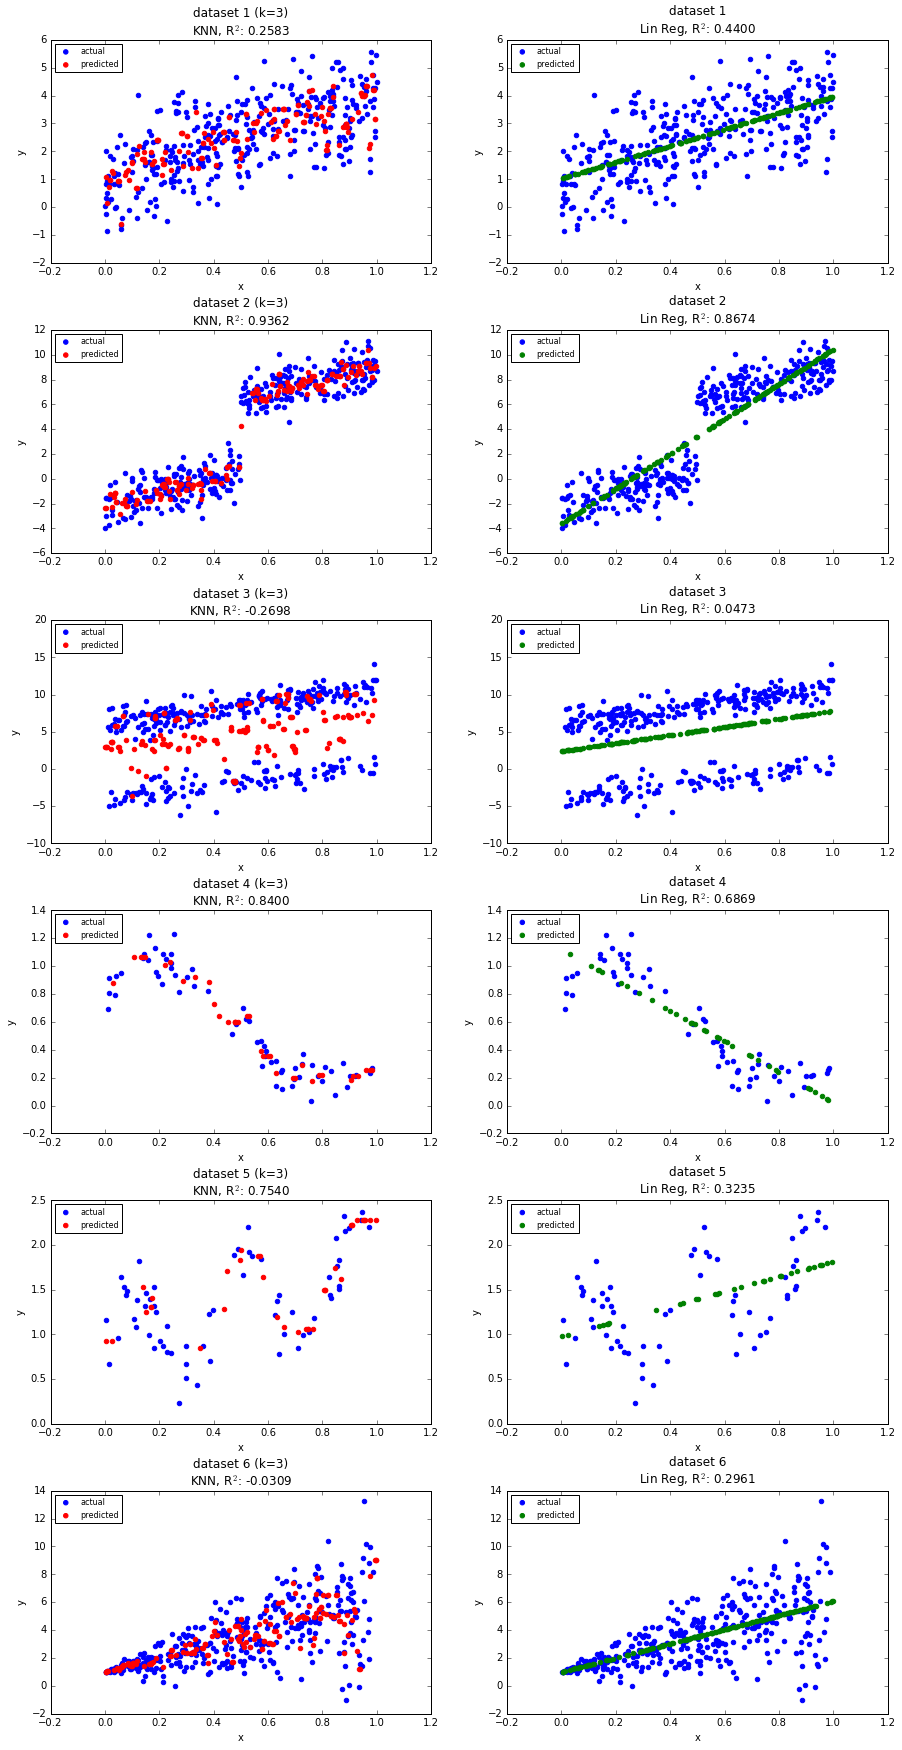

In [44]:
#create 6 x 2 subplot layout
dataset_count = 6
fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6), 
      (ax7, ax8),
      (ax9, ax10),
      (ax11, ax12)) = plt.subplots(dataset_count, 2, figsize=(15, 30))

#read in all the dataset paths
datasets = [('./dataset/dataset_{0}_missing.txt'.format(i+1), 
             './dataset/dataset_{0}_full.txt'.format(i+1))
             for i in xrange(dataset_count) ]

#fig.tight_layout()
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#add some space to allow my dataset title to fit
plt.subplots_adjust(hspace=0.3)

#create the subplots
nums = xrange(len(fig.axes)).__iter__()
for idx, (missing, full) in enumerate(datasets):
    left_pos = nums.next()
    right_pos = nums.next()
    fig.axes[left_pos], fig.axes[right_pos] = generate_knn_v_lr_plot('dataset {0}'.format(idx + 1), 
                                                            full, 
                                                            missing, 
                                                            fig.axes[left_pos], 
                                                            fig.axes[right_pos],
                                                            # real submission: k=10)
                                                            k=3) # k=3 while playing for midterm

plt.show()


#### Q: Use your analysis to form conjectures regarding the conditions under which KNN performs better than linear regression, under which linear regression performs better than KNN and under which both perform equally (well or poorly).  Explain in detail exactly what might cause each model to fail or perform well.

Generally speaking, and using the R<sup>2</sup> value as an indicator of accuracy, KNN performs better when there is a non-linear relationship between input and output variables, between x and y values in these examples.  
Datasets fitting these patterns would be:
* dataset 2 - per the plot there appears to be a linear relationship between subgroups where x < 0.5 and where x > 0.5 but when the full range is included the relationships is effectively non-linear (though likely some fancy word I could use to describe it accurately)
* dataset 4 - essentially S shaped, KNN does better
* dataset 5 - another S shaped but much more non-linear, i.e. wiggly, than 4. As a result there is a much greater R<sup>2</sup> difference between KNN & Linear Regression vs. in 4.  
  
Linear regression will perform better when there is indeed a linear relationship between variables.
Datasets with more of a linear relationship, determined essentially by viewing the plotted 'actual' data points:
* dataset 1 - high variance in y but definite linear relationship vs. x. The high variance results in neithr model doing too well but Linear Regression does win.
* dataset 3 - large spread of y variables again but with clusters that correlate with tigther sub-ranges of y-values. Neither model does great but KNN manages a negative R<sup>2</sup> and is definitely inferior.
* dataset 4 - linear relationship again, though the fan-shaped distribution indicates heteroscedasticity, where the variability of y values increases as the value of y increases. Relatively poor R<sup>2</sup> for both but again linear regression scores higher.



In [16]:
# Using dataset_1_missing.txt, explain the impact of the choice of k on the performance of KNN.

# re-purposing plot_missing, throwing away anything re linear regression plot
# I think I can hear matplotlib library screaming, but turning up my music seems to help (me)
def plot_knn(missing_df, full_df, ax1, ax2, k=10):
    
    no_y_ind = missing_df[missing_df['y'].isnull()].index
    with_y_ind = missing_df[missing_df['y'].notnull()].index

    predicted_knn, r_knn = fill_knn(missing_df, 
                                    full_df, 
                                    no_y_ind, 
                                    with_y_ind, 
                                    k)

    predicted_lin, r_lin = fill_lin_reg(missing_df, 
                                        full_df, 
                                        no_y_ind, 
                                        with_y_ind)

    ax1, ax2 = plot_missing(ax1, 
                            ax2, 
                            predicted_knn, r_knn,
                            predicted_lin, r_lin,
                            k,
                            no_y_ind, 
                            with_y_ind,
                            'dataset 1, K = {0}'.format(k),
                            plot_both=False)
    
    return ax1, r_knn


# call above, but only consume a single subplot 
def test_knn_k(k, ax_a, full_df, missing_df):
    
    ax, r_knn = plot_knn(missing_df, full_df, ax_a, ax_a, k)

    return ax, r_knn



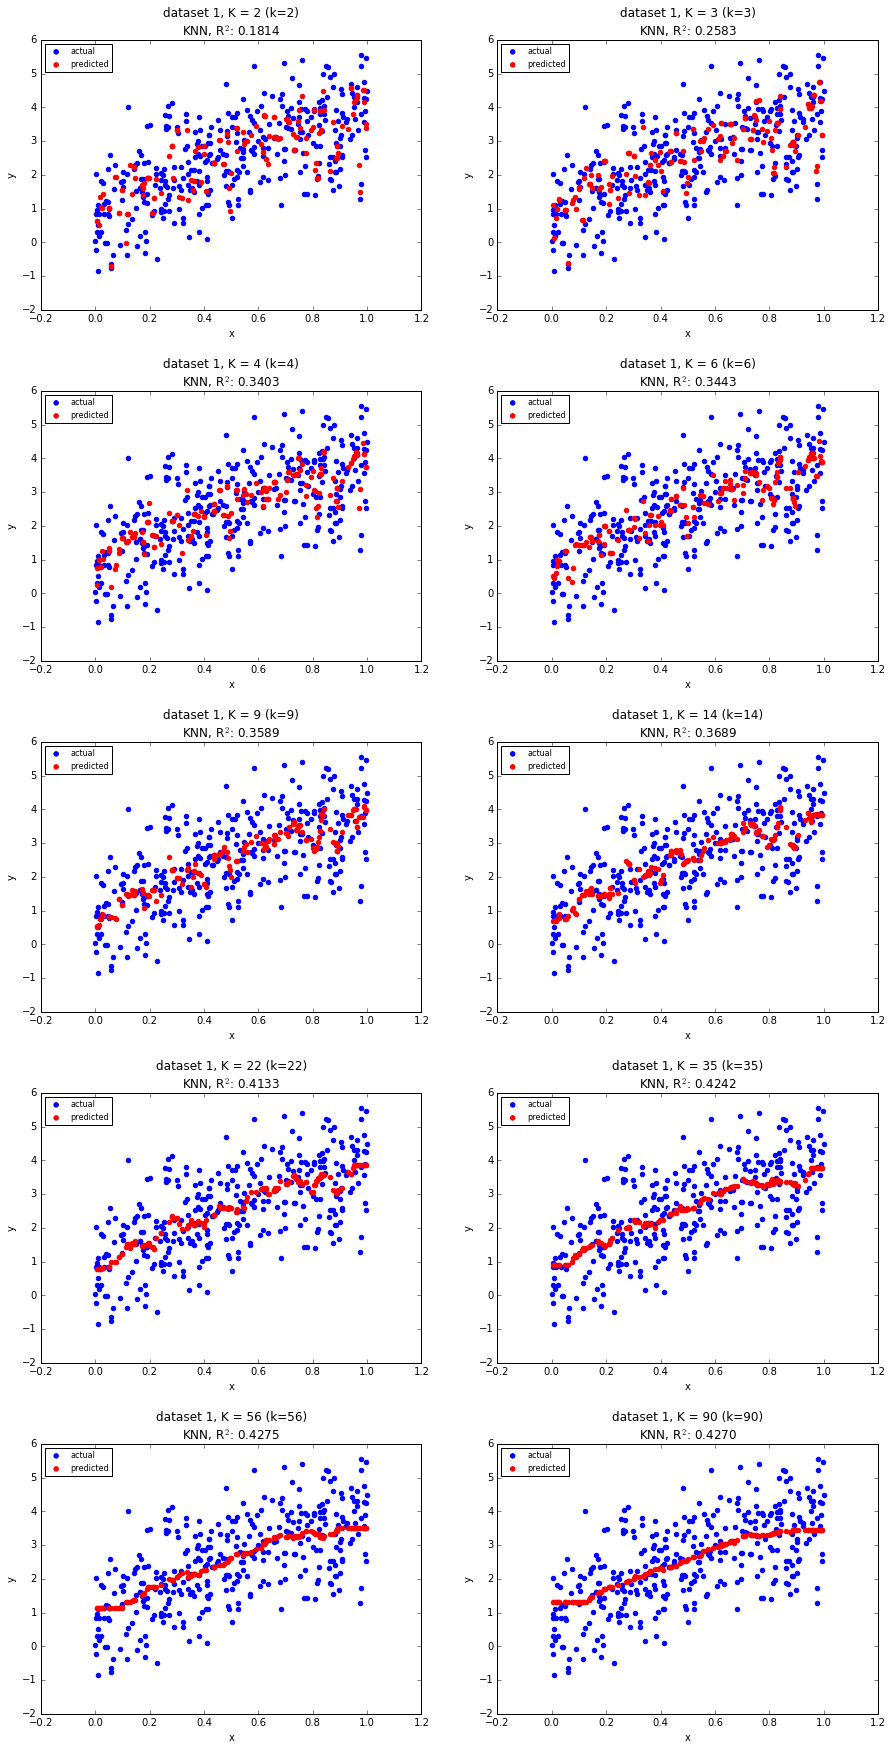

k R^2		improvement
1 0.181449293653 0.181449293653
2 0.258310285163 0.0768609915096
3 0.340334837971 0.082024552808
5 0.344286683952 0.0039518459815
8 0.358923984603 0.0146373006506
13 0.368856386144 0.00993240154105
21 0.413279766141 0.0444233799975
34 0.424153539456 0.0108737733147
55 0.427494184131 0.00334064467495
89 0.427019328592 -0.000474855538511


In [17]:

#5 x 2 series of subpots
fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6), 
      (ax7, ax8),
      (ax9, ax10)) = plt.subplots(5, 2, figsize=(15, 30))

#Read dataset 1
missing_df = pd.read_csv('./dataset/dataset_1_missing.txt')
full_df = pd.read_csv('./dataset/dataset_1_full.txt')

#series of k values to iteratively pass on to plotting function
# 500 records in dataset 1, below seem reasonable k values
vals = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
knn_perf = {}
for idx, val in enumerate(vals):
    ax, r_knn = test_knn_k(val+1, fig.axes[idx], full_df, missing_df)
    knn_perf[val] = r_knn
    
    
plt.subplots_adjust(hspace=0.3)
plt.show()
    
print 'k R^2\t\timprovement'
for i, k in enumerate(vals):
    prev_perf = 0 if i == 0 else knn_perf[vals[i-1]]
    print k, knn_perf[k],  knn_perf[k] - prev_perf


#### Q: impact of the choice of k on the performance of KNN  

Going both by the plots generated above for various values of K and the corresponding scores (R<sup>2</sup>), the accuracy of the model increases as K increases, albeit at a decreasing rate. The fibonacci sequence might make the analysis a little tricky but it is clear that the last jump, from 55 to 89, results in a small *decrease* in scoring. The chart progression is interesting in that the predicted values themselves begin to more and more resemble a straight line. I'm guessing if the relationship were non-linear to begin with, e.g. trying with dataset 5, the predicted values would be more line shaped, though of course not a straight line. Also notable that at only 500 observations, running analysis like above for various k values is trivial. With 500 million observations would take much more effort (time, computing power) to run through the iterations. 

---

## Problem 3: Is the Best (Linear Model) Good Enough?

In this problem, we will specifically look at conditions under which linear regression excels or fails.

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the dependent variable Y, and the second column containing the independent variable X. 

### Part (a): Introduction to Residual Plots

- Read ``dataset_1_full.txt``. Visualize the dataset and make some initial observations.


- For this data set, what can you say about the following linear fits: 

    1. slope = 0.4, intercept = 0.2
    2. slope = 0.4, intercept = 4
    3. linear regression model


- In each case, visualize the fit, compute the residuals, and make a residual plot of predicted values ~~against~~ residuals as well as a residual histogram. What do these plots reveal? 


- Calculate the R^2 coefficient for all three fits. What do the erors reveal? How do they compare to the residual plots?

**Solution:**

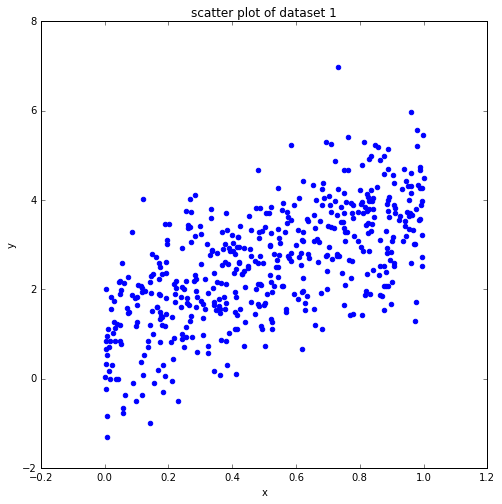

In [18]:
#simple scatterplot of all 500 points
full_df = pd.read_csv('./dataset/dataset_1_full.txt')

fig = plt.figure(figsize=(8,8))
axes_1 = fig.add_subplot(1, 1, 1)

axes_1.scatter(full_df['x'].values, 
            full_df['y'].values, 
            color='blue')
axes_1.set_title('scatter plot of dataset 1')
axes_1.set_xlabel('x')
axes_1.set_ylabel('y')

plt.show()

#### make some initial observations
There does indeed appear to be a linear relationship between independent (x) and dependent (y) variables, a positive one. Variance in the points generally seems to remain the same through values of x, i.e. is homoscedastic. One definite outlier at the top right but it really isn't too extreme and it is the only that really stands out, among 500 points of data.

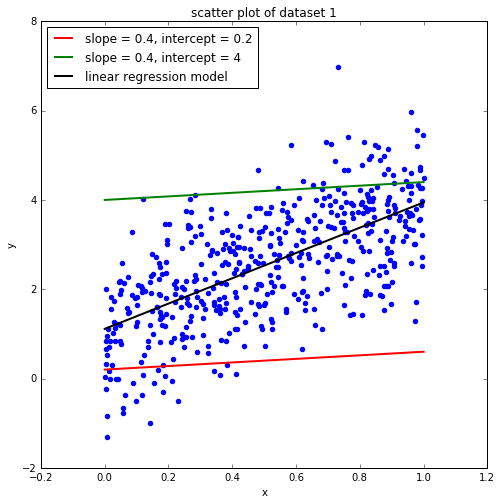

In [19]:
#For this data set, what can you say about the following linear fits:
fit_1 = 'slope = 0.4, intercept = 0.2'
fit_2 = 'slope = 0.4, intercept = 4'
fit_3 = 'linear regression model'

fig = plt.figure(figsize=(8,8))
axes_1 = fig.add_subplot(1, 1, 1)

axes_1.scatter(full_df['x'].values, 
            full_df['y'].values, 
            color='blue')
axes_1.set_title('scatter plot of dataset 1')
axes_1.set_xlabel('x')
axes_1.set_ylabel('y')

slope_1 = 0.4
intercept_1 = 0.2
axes_1.plot([0, 1], [intercept_1, slope_1 + intercept_1], c='r', label=fit_1, linewidth=2)

slope_2 = 0.4
intercept_2 = 4
axes_1.plot([0, 1], [intercept_2, slope_2 + intercept_2], c='g', label=fit_2, linewidth=2)

#here I've decided to read in the data again to be safe, to a test & train split
# and train the model only on the train data once again
full_df = pd.read_csv('./dataset/dataset_1_full.txt')
train_df, test_df = split(full_df, 70)
slope_ocg, intercept_ocg = linear_reg_fit(train_df)

#easy to plot line, since x values go from 0 to 1, don't need really 1.0 in end y value calc
axes_1.plot([0, 1], [intercept_ocg, (1.0 * slope_ocg) + intercept_ocg], c='black', label=fit_3, linewidth=2)

# slope, intercept from sklearn?  [[ 2.76075079]] [ 1.14097999]
# for kicks, rather close to my line
#axes_1.plot([0, 1], [1.14097999, (1.0 * 2.76075079) + 1.14097999], c='orange', label='sklearn', linewidth=2)

plt.legend(loc='upper left')
plt.show()

#print slope_ocg, intercept_ocg


#### linear fit(s) review
At first I was rather concerned that the slope/intercept of the lines to review were not similar to the values produced by my linear regression model. But then I noted that 'my' values (the black line) were close to those of sklearn and of course that my line seemed to fit the data better than the red and green ones did. That being said, my eyes tell me that the black line shoudl be a little steeper, with a lower intercept, in order to fit the data, so I'm not sure what happened there. The green and red lines of course share the same slope but I don't see much of a relationship for either vs. the actual data. Of course both data and red/green show a positive relationship between x and y but not much more to say. The vast majority of data points lie underneath the green line, so that model would consistently over-estimate y values. Conversely, almost all the data points are above the red line, so predictions from that model greatly underestimates y values.
It is important to note the plot includes all 500 points while only 350 were used to generate the linear regression model, so there maybe some variation in the training subpopulation. Though realistically I would think 350 would be enough to create a decent model.

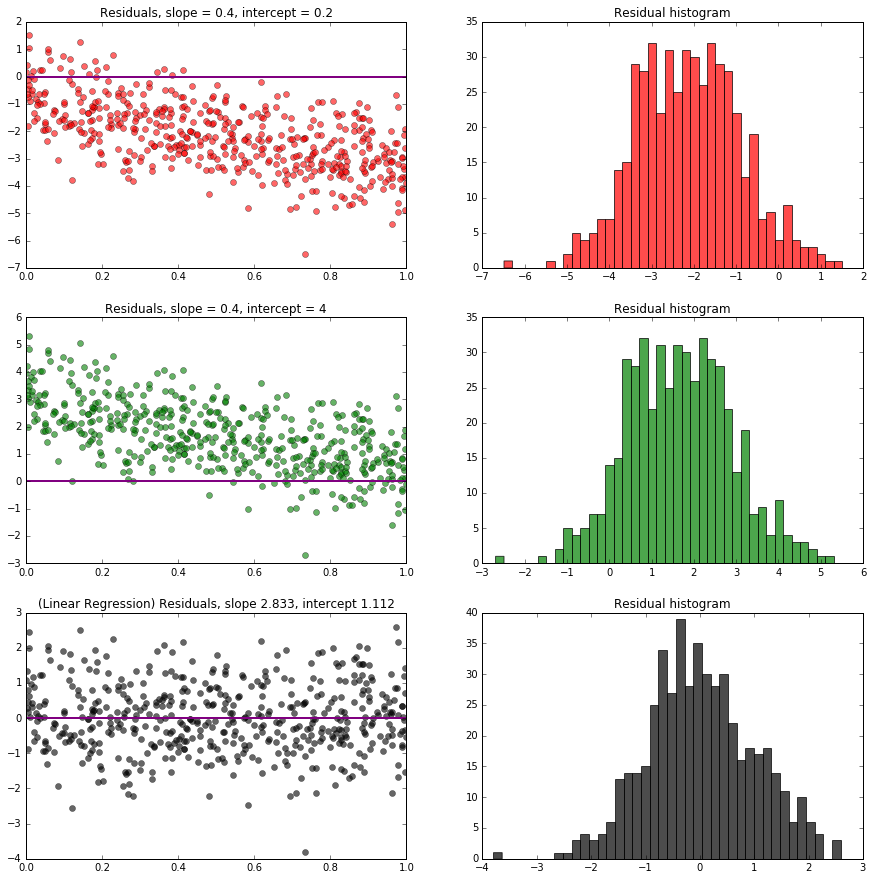

In [22]:
#In each case, visualize the fit, compute the residuals, and make a residual plot of predicted values 
#against residuals as well as a residual histogram. 

# some base code in the residual plot/histogram taken from lecture notebook

def calc_pred(x, slope, intercept):

    return x * slope + intercept

def calc_residual(df, slope, intercept):
    
    pred = calc_pred(df['x'], slope, intercept)
    residual = pred - full_df['y']
    
    return residual
    
    
#red
#slope_1 = 0.4
#intercept_1 = 0.2
residual_1 = calc_residual(full_df, slope_1, intercept_1)

#green
#slope_2 = 0.4
#intercept_2 = 4
residual_2 = calc_residual(full_df, slope_2, intercept_2)

#my model, hard-coded, black
#slope: 2.83289167586, intercept: 1.11234589821   at least on one of my fits
residual_3 = calc_residual(full_df, slope_ocg, intercept_ocg)


fig, ((ax1, ax2), 
       (ax3, ax4),
       (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))

#red, first residual plot / residual histogram pairing
ax1.set_title('Residuals, {0}'.format(fit_1))
ax1.plot(full_df['x'], residual_1, 'ro', alpha=0.6, label='Residuals')
ax1.axhline(y=0, color='purple', linewidth=2.0, label='y=0')
ax2.set_title('Residual histogram')
ax2.hist(residual_1, bins=40, alpha=0.7, color='r');

#green
ax3.set_title('Residuals, {0}'.format(fit_2))
ax3.plot(full_df['x'], residual_2, 'go', alpha=0.6, label='Residuals')
ax3.axhline(y=0, color='purple', linewidth=2.0, label='y=0')
ax4.set_title('Residual histogram')
ax4.hist(residual_2, bins=40, alpha=0.7, color='g');

#black, my model
ax5.set_title('(Linear Regression) Residuals, slope {0:.4}, intercept {1:.4}'.format(slope_ocg, intercept_ocg))
ax5.plot(full_df['x'], residual_3, 'ko', alpha=0.6, label='Residuals')
ax5.axhline(y=0, color='purple', linewidth=2.0, label='y=0')
ax6.set_title('Residual histogram')
ax6.hist(residual_3, bins=40, alpha=0.7, color='k');



#### What do these plots reveal?  
The distribution of the residuals, as revealed by the histogram plots, is normally distrubeted in each case (I played around with different bin numbers for each plot and changing bin level had relatively little effect on the shape of the ouput), illustrating that linear regression could in fact be a could choice for this dataset. The residual plot for linear regression shows residuals evenly spread around the mean, as we would expect with a good model. The residual plots for the first two examples do show a linear relationship, in that there aren't any strange shapes, e.g. curved pattern, in the plot. But of course the majority of values lie either above or below the y=0 mean line, indicating a poor fit to the data. In fact simply drawing a flat line at y=0 as a baseline, would be better than either of the first two fits.

In [24]:
#Calculate the R^2 coefficient for all three fits. 

#def score(actual, predicted):  
#    rss = sum((actual['y']-predicted['pred_y']) **2)
#    y_mean_actual = np.mean(actual['y'])
#    tss = sum((actual['y']-y_mean_actual) **2)
#    r_squared = 1 - (rss/tss)
#    return r_squared

# above score func defined earlier, but it expects what it expects, so adjust my data so it works as-is
pred_1 = calc_pred(full_df['x'], slope_1, intercept_1)
srs_pred_1 = pd.Series({ 'pred_y': pred_1})
r_1 = score(full_df, srs_pred_1)

pred_2 = calc_pred(full_df['x'], slope_2, intercept_2)
srs_pred_2 = pd.Series({ 'pred_y': pred_2})
r_2 = score(full_df, srs_pred_2)

pred_3 = calc_pred(full_df['x'], slope_ocg, intercept_ocg)
srs_pred_3 = pd.Series({ 'pred_y': pred_3})
r_3 = score(full_df, srs_pred_3)

print fit_1 + ', R^2: {0}'.format(r_1)
print fit_2 + ', R^2: {0}'.format(r_2)
print fit_3 + ', R^2: {0}'.format(r_3)


slope = 0.4, intercept = 0.2, R^2: -2.54429006179
slope = 0.4, intercept = 4, R^2: -1.49677532281
linear regression model, R^2: 0.430099528967


#### What do the erors reveal? How do they compare to the residual plots?  
As expected, the first two fits result in extremely poor R^2 values, indicating that little of the variation in the data can be explained by either of those 2 model/fits. The residual plots agree with that analysis, where the majority of residuals were well away from the y=0 baseline. The linear regression was a decent fit, though the variation in the data, visible in the initial scatter plot as well as the residual plot, illustrated linear regression could only do so much. If the residual plot was more tightly plotted around y=0, the model would be expected to do better, with a higher R^2 value. As it is, approzimately 40% of the total variation of the data can be explained by the linear regression model.

### Part (b): What do Residual Plots Reveal?

- Read datasets ``dataset_2_full.txt`` through ``dataset_6_full.txt``. In each case, visualize the fit of the linear regression model, compute the residuals, and make a residual plot of predicted values against residuals as well as a residual histogram. What do these plots reveal about the fit of the model? 


- Calculate the R^2 coefficient each fit. What do the erors reveal? How do they compare to the residual plots?


- Based on your analysis, form conjectures regarding the precise relationship between the residual plots and the fit of the linear regression model. Conjecture on the precise conditions under which linear regression model is an appropriate model for a given dataset.

**Solution:**

In [25]:
# this works in my jupyter, hoping Vocareum will render correctly

def generate_plots(full_df, slope, intercept, dataset_num):

    #slope, intercept = linear_reg_fit(full_df)
    
    #3 side by side sub-plots, scatter of full dataset, residual plot, histogram of residuals
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,  figsize=(20, 5))
    ax1.scatter(full_df['x'].values, 
                full_df['y'].values, 
                color='blue')
    ax1.set_title('scatter plot of dataset {0} '.format(dataset_num))
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    lbl = 'slope: {0:.2f}, intercept: {1:.2f}'.format(slope, intercept)
    ax1.plot([0, 1], [intercept, slope + intercept], c='black', label=lbl, linewidth=2)
    ax1.legend(loc='best')

    residual = calc_residual(full_df, slope, intercept)
    ax2.set_title('Residuals')
    ax2.plot(full_df['x'], residual, 'ro', alpha=0.6, label='Residuals')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y resid')
    ax2.axhline(y=0, color='purple', linewidth=2.0, label='y=0')

    ax3.set_title('Residual histogram')
    ax3.hist(residual_1, bins=40, alpha=0.7, color='r');
    ax3.set_xlabel('y resid')
    ax3.set_ylabel('resid frequency')

    #close so it doesn't immediately show, hopefully this fig close/display works on vocareum
    plt.close(fig)
    
    return fig



In [26]:
# don't love this, feel better having the fig generation as a separate function
# called from each 'dataset cell', but this is working and safer not to refactor again
def get_plots_and_r_squared(full_df):
    
    slope, intercept = linear_reg_fit(full_df)
    pred = calc_pred(full_df['x'], slope, intercept)
    srs_pred = pd.Series({ 'pred_y': pred})
    r = score(full_df, srs_pred)
    fig = generate_plots(full_df, slope, intercept, dataset_num)
    
    return fig, r


----------------------------------------------------------------------------------------------------

Dataset 2
r-squared: 0.8430


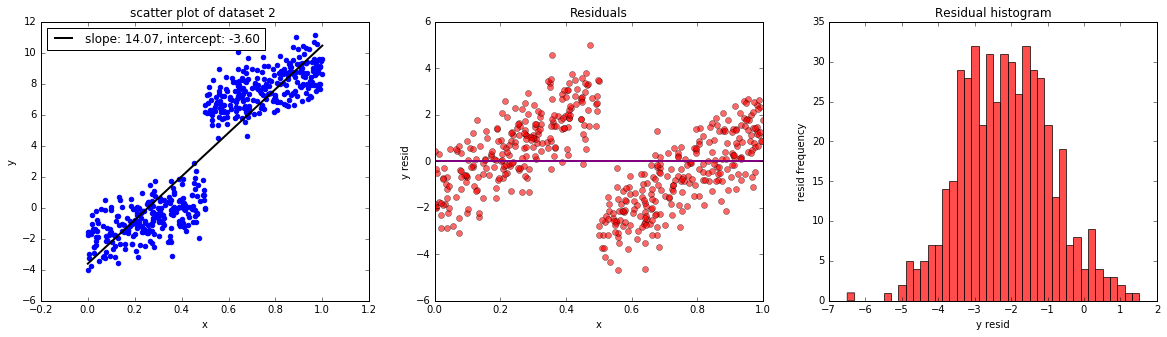

In [27]:
dataset_num = 2

full_df = pd.read_csv('./dataset/dataset_{0}_full.txt'.format(dataset_num))
fig, r = get_plots_and_r_squared(full_df)
print '-'*100
print
print 'Dataset {0}'.format(dataset_num)
print 'r-squared: {0:.4f}'.format(r)
fig
   

#### Dataset 2:
- fit of model
- error & residual plot analysis
- residual plot vs. model fit
- linear regression approach for this dataset?
-----------------
R<sup>2</sup> is rather high, implying a good fit, not the value I would have expected ... but I guess the values are tightly clustered around the line. Likewise the residual plot shows relatively little variation compared to the other datasets - which is not immediately apparent in a visual comparison as the y axis range differs a good bit among the various residual plots. The clusterd aspect of the dataset is reflected in the residual plot and I'm not sure what to make of the shapes. The residual histogram has a normal distribution, supporting the case for linear regression. I wouldn't have thought the linear regression would work so well on this dataset, simple because it looked "non-standard", but in fact it works well here.



----------------------------------------------------------------------------------------------------

Dataset 3
r-squared: 0.0779


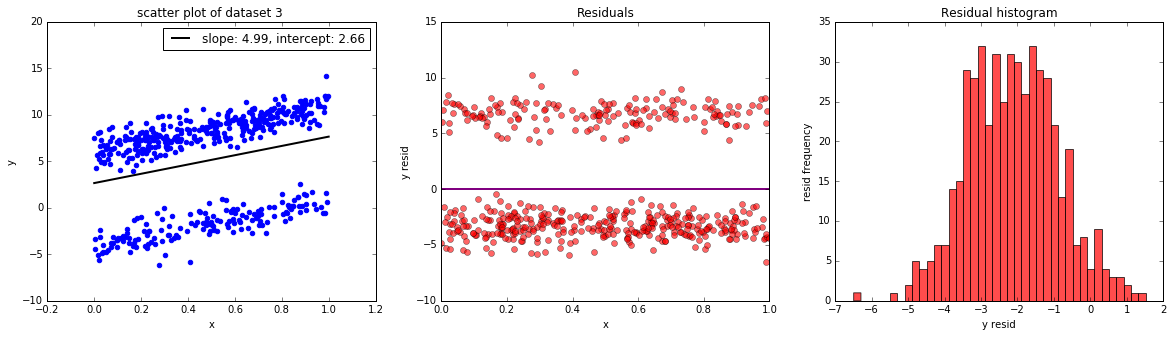

In [28]:
dataset_num = 3

full_df = pd.read_csv('./dataset/dataset_{0}_full.txt'.format(dataset_num))
fig, r = get_plots_and_r_squared(full_df)
print '-'*100
print
print 'Dataset {0}'.format(dataset_num)
print 'r-squared: {0:.4f}'.format(r)
fig

#### Dataset 3:
- fit of model
- error & residual plot analysis
- residual plot vs. model fit
- linear regression approach for this dataset?
-----------------
Now comes a dataset that has a sub-optimal fit vs. the model. Rather sub-optimal, with a R<sup>2</sup> that approaches zero. Having the data clustered in two distinct ranges that span the full independent value range leads to a model that draws a prediction in parallel to the two groups, though closer to the upper one as it has more datapoints. The residual plot shows that very few points are close to the model, here the greater set of datapoints appear as negative residuals, so not an even distribution. The histogram looks like a gaussian distribution, but that doesn't matter so much in terms of how appropriate the dataset is for linear regression overall, because it doesn't appear to be.



----------------------------------------------------------------------------------------------------

Dataset 4
r-squared: 0.7581


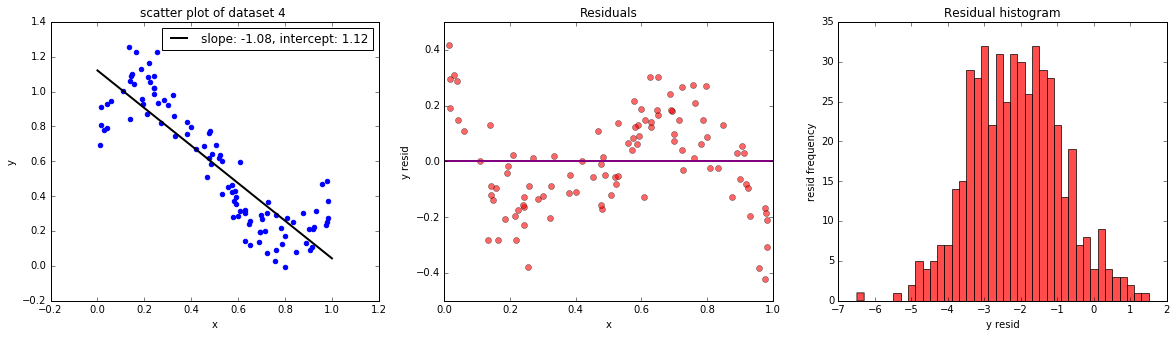

In [29]:
dataset_num = 4

full_df = pd.read_csv('./dataset/dataset_{0}_full.txt'.format(dataset_num))
fig, r = get_plots_and_r_squared(full_df)
print '-'*100
print
print 'Dataset {0}'.format(dataset_num)
print 'r-squared: {0:.4f}'.format(r)
fig

#### Dataset 4:
- fit of model
- error & residual plot analysis
- residual plot vs. model fit
- linear regression approach for this dataset?
-----------------
Many fewer points here, comparitively speaking, but the R<sup>2</sup> is good and there are still at least 50 (?). The shape of the residual plot is a warning sign though, since there is a faint curved shape there, which might be even more obvious with more datapoints. That causes me to look at the first scatter plot and pay more attention to what may be something of an S shaped curve. Residual histogram is normal shaped, and no warnings there to me. So I would say linear regression is appropriate with some caveats. Perhaps there are additional tests to be performed on this dataset before saying it is ok for LR.



----------------------------------------------------------------------------------------------------

Dataset 5
r-squared: 0.2984


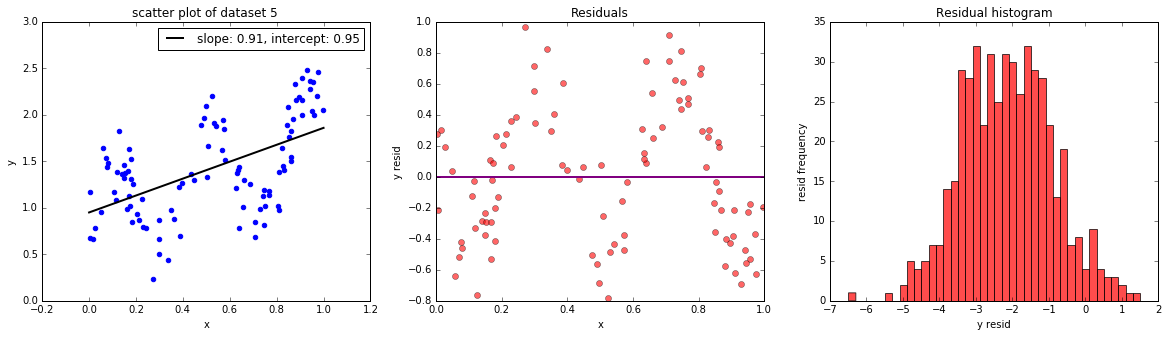

In [30]:
dataset_num = 5

full_df = pd.read_csv('./dataset/dataset_{0}_full.txt'.format(dataset_num))
fig, r = get_plots_and_r_squared(full_df)
print '-'*100
print
print 'Dataset {0}'.format(dataset_num)
print 'r-squared: {0:.4f}'.format(r)
fig

#### Dataset 5:
- fit of model
- error & residual plot analysis
- residual plot vs. model fit
- linear regression approach for this dataset?
-----------------
Low R<sup>2</sup>, definite non-linear shape, looks like a sine curve, not too many data points. Residual plot agrees, the shape is present there also. Histogram looks fine, as with the other datasets. The R<sup>2</sup> isn't necessarily bad but the shape of the data points in the scatter plot is a big deal. There appears to be a definite relationship between x and y but it is a non-linear one.

----------------------------------------------------------------------------------------------------

Dataset 6
r-squared: 0.3834


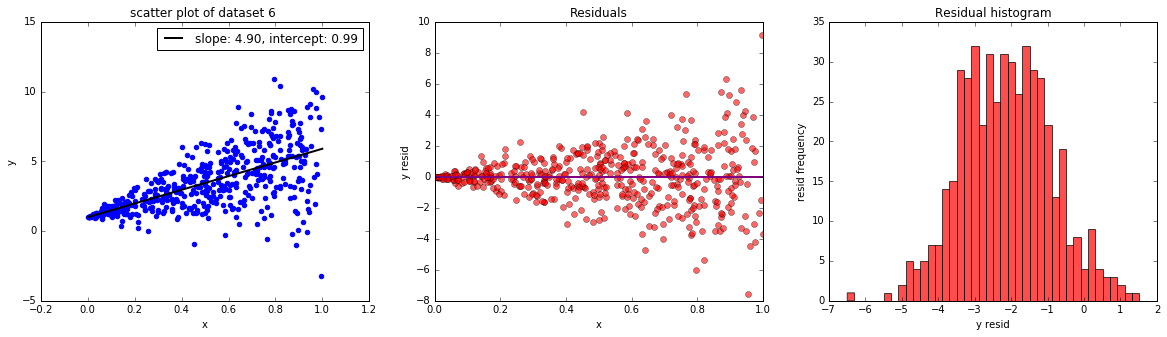

In [31]:
dataset_num = 6

full_df = pd.read_csv('./dataset/dataset_{0}_full.txt'.format(dataset_num))
fig, r = get_plots_and_r_squared(full_df)
print '-'*100
print
print 'Dataset {0}'.format(dataset_num)
print 'r-squared: {0:.4f}'.format(r)
fig

#### Dataset 6:
- fit of model
- error & residual plot analysis
- residual plot vs. model fit
- linear regression approach for this dataset?
-----------------
The R<sup>2</sup> isn't necessarily too poor but the scatter plot and the residual plot both send up warning flares as the y variation from the mean is increasing as x increases. I'm guessing there are things that can be done to help with predictions related to data like this but I certainly don't know if there is anything in the linear regression toolbos. So I'm going to say linear regression would not be appropriate.  
(nice looking residual histogram once again though)



---

## Challenge Problem: Combining Random Variables

This problem, we explore the distirbution of random variables that result from combining other random variables.

### Part (a): Adding Two Uniformly Distributed Variables

Consider the independent random variables $X\sim U(0, 1)$ and $Y\sim U(0, 1)$. Let $Z$ be the random variable $Z = X + Y$. 

What is the distribution of $Z$ (give the pdf for Z)? You should fully explain and support your conlusion. 

**Hint:** your solution can be a combination of experimentation, empirical evidence and/or algebra

**Solution:**

### *42* 

### Part (b): Adding Multiple Uniformly Distributed Variables

Consider three independent random variables $X_1, X_2, X_3 \sim U(0, 1)$. Let $Z$ be the random variable $Z = X_1 + X_2 + X_3$. 

What is the distribution of $Z$? What if you add 10 or 12 independent (standard) uniformly distributed variables? Conjecture on the distribution of 
$$
Z = \lim_{n\to \infty} \sum_{i=1}^n X_i
$$
where $\left\{X_i \right\}$ are independent (standard) uniformly distributed variables.

**Hint:** your solution can be a combination of experimentation, empirical evidence and/or algebra

**Solution:**

### Part (c): Combining Normally Distributed Variables

Consider the independent random variables $X\sim \mathcal{N}(0, 1)$ and $Y\sim \mathcal{N}(0, 1)$. Let $Z$ be the random variable $Z = X + Y$. 

What is the distribution of $Z$ (give the pdf for Z)? You should fully explain and support your conlusion. 

**Hint:** use properties of expected value and some experimentation.

**Solution:**

### Part (d): Product of Normally Distributed Variables

Is the product of two normally distributed variables a normally distributed variable? You should fully explain and support your conlusion. 

**Solution:**

---